In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.metrics import dtw, soft_dtw

In [2]:
def calc_bic(X_train, km, k_cluster, soft=0):
    bic = 0
    for n in range(len(X_train)):
        p_sum = 0
        for i in range(k_cluster):
            if soft == 0:
                dist = dtw(X_train[n], km.cluster_centers_[i])
            elif soft == 1:
                dist = soft_dtw(X_train[n], km.cluster_centers_[i], gamma=0.01)
            p_ = np.exp(-(dist**2)/2) / (2*np.pi)**(1/2)
            p_sum += p_
        
        bic -= np.log(p_sum / k_cluster)
    bic += k_cluster * X_train.shape[1] * np.log(X_train.shape[0]) / 2

    return bic

def calc_aic(X_train, km, k_cluster, soft=0):
    aic = 0
    for n in range(len(X_train)):
        p_sum = 0
        for i in range(k_cluster):
            if soft == 0:
                dist = dtw(X_train[n], km.cluster_centers_[i])
            elif soft == 1:
                dist = soft_dtw(X_train[n], km.cluster_centers_[i], gamma=0.01)
            p_ = np.exp(-(dist**2)/2) / (2*np.pi)**(1/2)
            p_sum += p_
        
        aic -= np.log(p_sum / k_cluster)
    aic += k_cluster * X_train.shape[1]

    return aic

In [5]:
seed = 0
np.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# Keep only 50 time series

# Make time series shorter
# X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

# DBA-k-means
aic_li = []
km_li = []
for i in range(5):
    k_cluster = i+1

    print(f'DBA k-means {k_cluster}')
    dba_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                n_init=2,
                                metric="dtw",
                                verbose=False,
                                max_iter_barycenter=10,
                                random_state=seed)
    y_pred = dba_km.fit_predict(X_train)
    km_li.append(dba_km)
    aic_li.append(calc_aic(X_train, dba_km, k_cluster, 0))

    print('aic: ', aic_li[i])

DBA k-means 1
aic:  1439.4837968897282
DBA k-means 2
aic:  842.2709885518707
DBA k-means 3
aic:  1063.6860956028827
DBA k-means 4
aic:  1346.5196815689737
DBA k-means 5
aic:  1633.5417888848976


In [6]:
best_ind = np.argmin(aic_li)
best_k = best_ind + 1


for yi in range(best_k):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
            transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

1

/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_39156/810905680.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


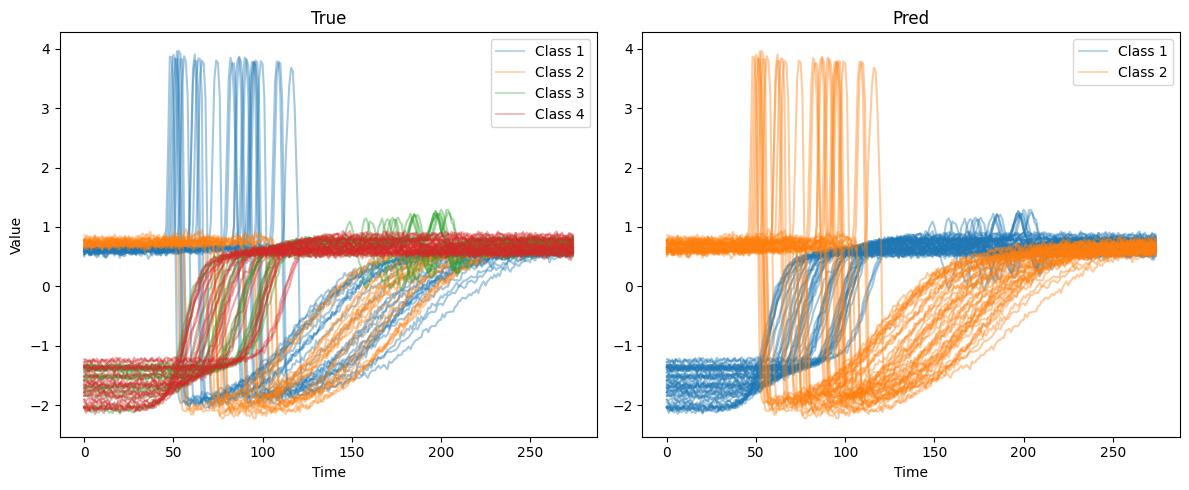

In [73]:
plt.figure(figsize=(12,5))

# true
plt.subplot(1, 2, 1)
label = np.unique(y_train)
# カラーマップを定義
cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
colors = [cmap(i) for i in range(len(label))]

for class_label in label:
    class_data = X_train[y_train == class_label][:,:,0].T
    plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
    plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

plt.legend()
# plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True')

# pred
plt.subplot(1,2,2)
best_ind = np.argmin(aic_li)
best_k = best_ind + 1
best_km = km_li[best_ind]
y_pred = best_km.predict(X_train) + 1

label = np.unique(y_pred)
# カラーマップを定義
cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
colors = [cmap(i) for i in range(len(label))]

for class_label in label:
    class_data = X_train[y_pred == class_label][:,:,0].T
    plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
    plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

plt.legend()
# plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
plt.xlabel('Time')
plt.title('Pred')
plt.tight_layout()
plt.show()